In [37]:
import stim
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from math import comb

In [38]:
class BCH_Code:
    """
    Generic class for BCH cyclic codes.
    Parameters n, k, t, generator polynomial g_poly.
    """
    def __init__(self, n, k, t, g_poly):
        self.n = n
        self.k = k
        self.t = t
        
        # parity polynomial h(x) = (x^n - 1) / g(x)
        h_poly = self._poly_div_gf2(self.n, g_poly)
        
        # parity check matrix H
        self.num_checks = self.n - self.k
        self.H = np.zeros((self.num_checks, self.n), dtype=np.uint8)
        h_rev = np.flip(h_poly)
        for r in range(self.num_checks):
            self.H[r, r:r+len(h_rev)] = h_rev

        # syndrome table
        self.lookup = {}
        
        # 0 Errors
        self.lookup[self._key(np.zeros(self.num_checks, dtype=np.uint8))] = np.zeros(self.n, dtype=np.uint8)
        
        # 1 to t Errors
        for w in range(1, self.t + 1):
            for locs in combinations(range(self.n), w):
                e = np.zeros(self.n, dtype=np.uint8)
                e[list(locs)] = 1
                
                syn = (self.H @ e) % 2
                self.lookup[self._key(syn)] = e

    def theoretical_pL(self, p):
        """Calculates theoretical failure rate (errors > t)."""
        # Sum probabilities of k errors where k is from t+1 to n
        return sum(comb(self.n, k) * (p**k) * ((1-p)**(self.n-k)) 
                   for k in range(self.t + 1, self.n + 1))

    def _poly_div_gf2(self, n, divisor):
        """Computes (x^n + 1) / divisor in GF(2)."""
        dividend = np.zeros(n + 1, dtype=np.uint8)
        dividend[0] = 1; dividend[n] = 1
        quotient = np.zeros(n + 1, dtype=np.uint8)
        remainder = dividend.copy()
        deg_div = len(divisor) - 1
        
        while True:
            non_zeros = np.where(remainder)[0]
            if len(non_zeros) == 0: break
            deg_rem = non_zeros[-1]
            if deg_rem < deg_div: break
            
            diff = deg_rem - deg_div
            quotient[diff] = 1
            shifted_divisor = np.zeros(len(remainder), dtype=np.uint8)
            shifted_divisor[diff : diff + len(divisor)] = divisor
            remainder = (remainder + shifted_divisor) % 2
            
        last_nonzero = np.max(np.where(quotient)[0])
        return quotient[:last_nonzero+1]

    def _key(self, array):
        return array.tobytes()

In [69]:
def run_simulation(bch, probs):
    """
    Runs the simulation using the quantum circuit logic (Ancillas + CNOTs).
    """
    results = []
    theory = []
    
    print(f"{'p_phys':<10} | {'p_logical':<12} | {'theory':<12}")
    
    # INDICES SETUP
    n = bch.n
    m = bch.num_checks
    data_qubits = list(range(n))
    anc_qubits = list(range(n, n + m))

    for p in probs:
        circuit = stim.Circuit()

        circuit.append("R", data_qubits + anc_qubits)
        circuit.append("TICK")

        circuit.append("X_ERROR", data_qubits, p)
        circuit.append("TICK")
  
        for i, row in enumerate(bch.H):
            targets = []
            a = anc_qubits[i]
            for j, bit in enumerate(row):
                if bit:
                    targets += [j, a]
            
            if targets:
                circuit.append("CX", targets)
            circuit.append("TICK")
            
        circuit.append("M", anc_qubits)
        
        for i in range(m):
            circuit.append("DETECTOR", [stim.target_rec(-m + i)], [i, 0])

        circuit.append("M", data_qubits)
        
        shots = 1_000_000
        sampler = circuit.compile_sampler()
        samples = sampler.sample(shots=shots)
        
        fails = 0   
        for i in range(shots):
            full_readout = samples[i]

            syndrome_bits = full_readout[:m]
            noisy_data = full_readout[m:]
            
            syn_key = syndrome_bits.tobytes()
            
            if syn_key in bch.lookup:
                correction = bch.lookup[syn_key]
                final_state = (noisy_data + correction) % 2
                
                # Logic Failure Check
                if np.any(final_state):
                    fails += 1
            else:
                fails += 1
                
        p_sim = fails / shots
        p_th = bch.theoretical_pL(p)
        
        results.append(p_sim)
        theory.append(p_th)
        
        print(f"{p:<10.4f} | {p_sim:<12.6f} | {p_th:<12.6f}")

    return results, theory

p_phys     | p_logical    | theory      
0.0010     | 0.000001     | 0.000000    
0.0020     | 0.000004     | 0.000004    
0.0030     | 0.000013     | 0.000012    
0.0050     | 0.000057     | 0.000054    
0.0080     | 0.000220     | 0.000217    
0.0100     | 0.000397     | 0.000416    
0.0200     | 0.002997     | 0.003039    
0.0300     | 0.009511     | 0.009371    
0.0400     | 0.020510     | 0.020292    
0.0500     | 0.035905     | 0.036200    
0.0800     | 0.112959     | 0.112965    


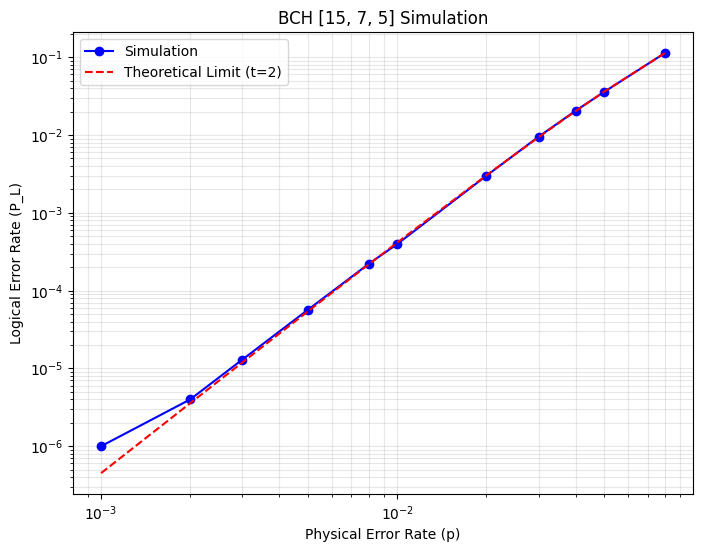

In [70]:
if __name__ == "__main__":
    N = 15
    K = 7
    T = 2
    
    # low to high
    G_POLY = np.array([1, 0, 0, 0, 1, 0, 1, 1, 1], dtype=np.uint8) 

    my_code = BCH_Code(n=N, k=K, t=T, g_poly=G_POLY)
    probabilities = [0.001, 0.002, 0.003, 0.005, 0.008, 0.01, 0.02, 0.03, 0.04, 0.05, 0.08]
    sim_res, th_res = run_simulation(my_code, probabilities)
    
    # plot
    plt.figure(figsize=(8, 6))
    plt.loglog(probabilities, sim_res, 'o-', color='blue', label='Simulation')
    plt.loglog(probabilities, th_res, 'r--', label=f'Theoretical Limit (t={T})')
    plt.xlabel('Physical Error Rate (p)')
    plt.ylabel('Logical Error Rate (P_L)')
    plt.title(f'BCH [{N}, {K}, {2*T+1}] Simulation')
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.show()

p_phys     | p_sim        | p_theory    
----------------------------------------
0.0010     | 0.000000     | 0.000021    
0.0030     | 0.000340     | 0.000187    
0.0050     | 0.000460     | 0.000516    
0.0100     | 0.002000     | 0.002031    
0.0200     | 0.007620     | 0.007857    
0.0400     | 0.028340     | 0.029380    
0.0600     | 0.058000     | 0.061777    


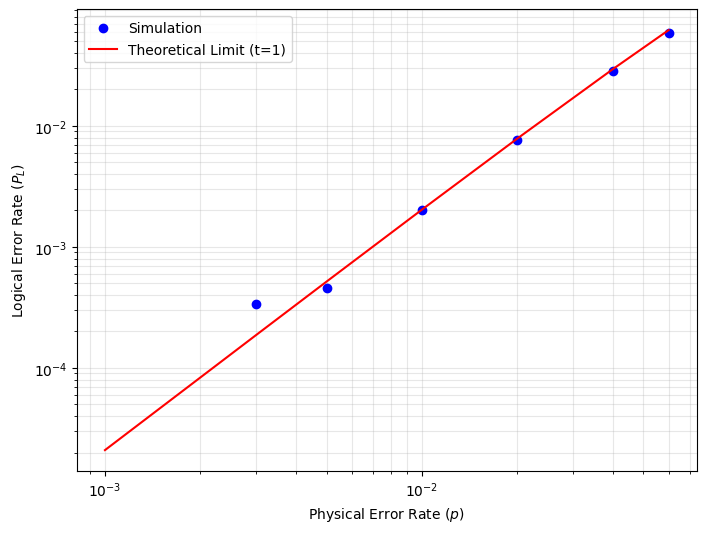

In [46]:
import stim
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from math import comb

class CSS_Circuit_Builder:
    def __init__(self, Hx, Hz, n):
        self.Hx = Hx.astype(np.uint8)
        self.Hz = Hz.astype(np.uint8)
        self.n = n
        
        # Validate CSS Condition
        if np.any((self.Hx @ self.Hz.T) % 2):
            print("WARNING: Hx and Hz do not commute! Invalid CSS code.")

        self.num_x_checks = self.Hx.shape[0]
        self.num_z_checks = self.Hz.shape[0]
        self.total_qubits = self.n + self.num_x_checks + self.num_z_checks
        
        self.data_qubits = list(range(self.n))
        self.x_ancillas = list(range(self.n, self.n + self.num_x_checks))
        self.z_ancillas = list(range(self.n + self.num_x_checks, self.total_qubits))

    def build_circuit(self, p_phys):
        circuit = stim.Circuit()
        circuit.append("R", range(self.total_qubits))

        circuit.append("X_ERROR", self.data_qubits, p_phys)

        for row_idx, ancilla_idx in enumerate(self.z_ancillas):
            targets = np.where(self.Hz[row_idx])[0]
            for t in targets:
                circuit.append("CX", [t, ancilla_idx])
                
        for row_idx, ancilla_idx in enumerate(self.x_ancillas):
            targets = np.where(self.Hx[row_idx])[0]
            circuit.append("H", [ancilla_idx])
            for t in targets:
                circuit.append("CX", [ancilla_idx, t])
            circuit.append("H", [ancilla_idx])

        circuit.append("M", self.x_ancillas + self.z_ancillas + self.data_qubits)
        return circuit

class CSS_Decoder:
    def __init__(self, H, n, max_errors=1):
        self.H = H
        self.n = n
        self.lookup = {}
        
        num_checks = H.shape[0]
        self.lookup[self._key(np.zeros(num_checks, dtype=np.uint8))] = np.zeros(n, dtype=np.uint8)
        
        for w in range(1, max_errors + 1):
            for locs in combinations(range(n), w):
                e = np.zeros(n, dtype=np.uint8)
                e[list(locs)] = 1
                syn = (H @ e) % 2
                k = self._key(syn)
                if k not in self.lookup:
                    self.lookup[k] = e
                    
    def _key(self, array):
        return array.tobytes()
    
    def decode(self, syndrome):
        return self.lookup.get(self._key(syndrome), np.zeros(self.n, dtype=np.uint8))


def get_theoretical_pL(p, n, t):
    """
    Calculates the probability that > t errors occur.
    For Steane [[7,1,3]], t=1.
    """
    return sum(comb(n, k) * (p**k) * ((1-p)**(n-k)) for k in range(t + 1, n + 1))

def run_quantum_simulation(Hx, Hz, n, t, probs):
    builder = CSS_Circuit_Builder(Hx, Hz, n)
    x_decoder = CSS_Decoder(Hz, n, max_errors=t)
    
    sim_results = []
    theo_results = []
    
    print(f"{'p_phys':<10} | {'p_sim':<12} | {'p_theory':<12}")
    print("-" * 40)

    for p in probs:
        # A. Run Simulation
        circuit = builder.build_circuit(p)
        sampler = circuit.compile_sampler()
        shots = 50_000
        samples = sampler.sample(shots=shots)
        
        fails = 0
        num_x = builder.num_x_checks
        num_z = builder.num_z_checks
        
        for i in range(shots):
            meas = samples[i]
            z_syn = meas[num_x : num_x + num_z] 
            raw_data = meas[num_x + num_z :]
            
            correction = x_decoder.decode(z_syn)
            final_data = (raw_data + correction) % 2
            
            if np.sum(final_data) % 2 != 0:
                fails += 1
                
        p_sim = fails / shots
        sim_results.append(p_sim)
        
        # B. Calculate Theory
        p_th = get_theoretical_pL(p, n, t)
        theo_results.append(p_th)
        
        print(f"{p:<10.4f} | {p_sim:<12.6f} | {p_th:<12.6f}")
        
    return probs, sim_results, theo_results

# ==============================================================================
# 5. MAIN
# ==============================================================================
if __name__ == "__main__":
    # Steane [[7,1,3]] setup
    H_steane = np.array([
        [0,0,0,1,1,1,1],
        [0,1,1,0,0,1,1],
        [1,0,1,0,1,0,1]
    ], dtype=np.uint8)
    
    N = 7
    T = 1
    probabilities = [0.001, 0.003, 0.005, 0.01, 0.02, 0.04, 0.06]
    
    # Run
    p_phys, p_sim, p_th = run_quantum_simulation(H_steane, H_steane, N, T, probabilities)
    
    # Plot
    plt.figure(figsize=(8, 6))
    
    # 1. Simulation
    plt.loglog(p_phys, p_sim, 'o', color='blue', label='Simulation')
    
    # 2. Theory
    plt.loglog(p_phys, p_th, 'r-', label='Theoretical Limit (t=1)')
    
    
    plt.xlabel('Physical Error Rate ($p$)')
    plt.ylabel('Logical Error Rate ($P_L$)')
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.show()

In [61]:
# Goal: try to implement a [[15, 7, 5]] code (that allows correction of 2 errors) using BCH codes, and benchmark its performance against cat-repetition codes of similar length
# We'll assume strong noise bias conditions, focusing on bit-flip (X) errors

# From math derivations, we know that a BCH [[15, 7, 5]] code is associated with the following generator polynomial g(x) and parity check polynomial h(x):
# g(x) = x^8 + x^7 + x^6 + x^4 + 1
# h(x) = (x^15 - 1) / g(x) = x^7 + x^6 + x^4 + 1
# and the parity check matrix H can be constructed from h(x) as follows:
H = np.array([
    [1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1],
])
# Each row of H corresponds to a stabilizer generator measuring the parity of a subset of qubits

# We are gonna start with the trivial state |0...0>
# To recover from bit-flip errors, the easiest way is to use a brute force lookup-table

def get_syndrome(H: np.ndarray, e: np.ndarray) -> np.ndarray:
    """
    Compute the syndrome s = H e^T (mod 2) for the error pattern e.
    
    Args:
        H: Parity check matrix of shape (m, n).
        e: Error pattern vector of shape (n, ).
        
    Returns:
        s: Syndrome vector of shape (m, ).
    """
    return (H @ e) % 2

def create_lookup_table(H: np.ndarray, max_weight=15) -> dict:
    """
    Create a lookup table mapping syndromes to error patterns for the BCH [[15, 7, 5]] code.
    
    Args:
        H: Parity check matrix of shape (m, n).
        max_weight: Maximum weight of error patterns to consider.

    Returns:
        lookup_table: Dictionary mapping syndrome tuples to error pattern arrays.
    """
    lookup_table = {}
    n = H.shape[1]
    from itertools import combinations
    for w in range(0, max_weight + 1):
        for error_positions in combinations(range(n), w):
            e = np.zeros(n, dtype=int)
            e[list(error_positions)] = 1
            s = get_syndrome(H, e)
            s_tuple = tuple(s)
            if s_tuple not in lookup_table:
                lookup_table[s_tuple] = e
    return lookup_table

def apply_correction(r: np.ndarray, e: np.ndarray) -> np.ndarray:
    """
    Apply the correction e to the received pattern r.
    
    Args:
        r: Received pattern vector of shape (n, ).
        e: Error pattern vector of shape (n, ).
        
    Returns:
        c: Corrected codeword vector of shape (n, ).
    """
    return (r + e) % 2

def simulate(p: float):
    m = 8
    n = 15
    
    def create_circuit():
        data = list(range(n))
        anc = list(range(n, n + m))
        
        circuit = stim.Circuit()
        circuit.append("R", data + anc)
        circuit.append("TICK")
        circuit.append(f"X_ERROR", data, p)
        circuit.append("TICK")
        
        for i, row in enumerate(H):
            targets = []
            a = anc[i]
            for j, bit in enumerate(row):
                if bit:
                    targets += [j, a]
            if targets:
                circuit.append("CX", targets)
            circuit.append("TICK")
            
        circuit.append("M", anc)
        
        for i in range(m):
            circuit.append("DETECTOR", [stim.target_rec(-m + i)], [i, 0])
            
        circuit.append("M", data)
        return circuit
    
    circuit = create_circuit()
    lookup_table = create_lookup_table(H)
    
    sampler = circuit.compile_sampler()
    shots = 100_000
    results = sampler.sample(shots=shots)
    
    logical_errors = 0
    for shot in results:
        synd = tuple(shot[:m])
        r = np.array(shot[m:])
        
        # CASE 1: Syndrome not in table (Automatic Failure)
        if synd not in lookup_table:
            logical_errors += 1
            continue  # Skip to the next shot immediately!
    
        # CASE 2: Syndrome found, apply correction
        e = lookup_table[synd]
        c = apply_correction(r, e) # (r + e) % 2
        
        if np.any(c):
            logical_errors += 1
            
    logical_error_rate = logical_errors / shots
    return logical_error_rate
    

In [62]:
def get_ler_t(p: float) -> float:
    return sum(comb(15, k) * (p**k) * ((1-p)**(15-k)) 
                   for k in range(3, 16))

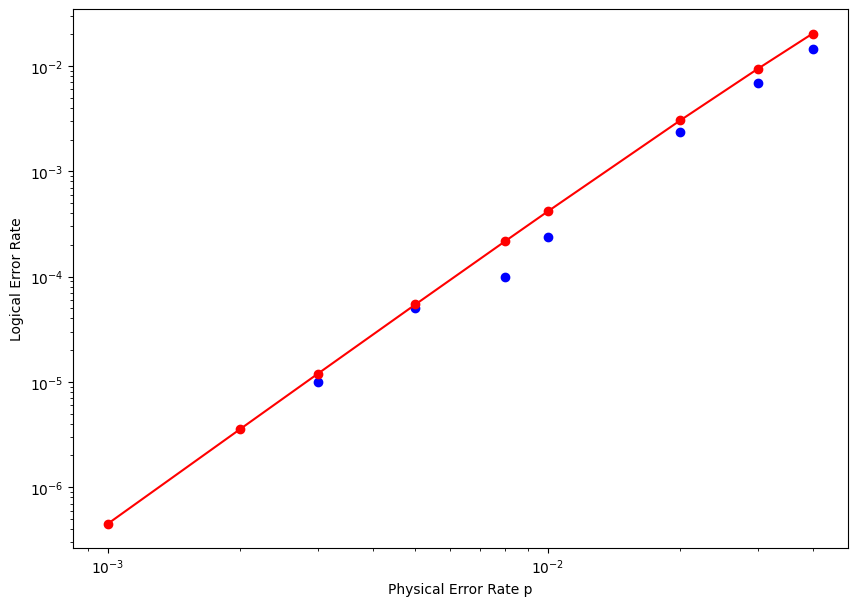

In [64]:
exp_lers = []
ps = [0.001, 0.002, 0.003, 0.005, 0.008, 0.01, 0.02, 0.03, 0.04]
for p in ps:
    exp_ler = simulate(p)
    exp_lers.append(exp_ler)
    
plt.figure(figsize=(10, 7))
plt.scatter(ps, exp_lers, label='Simulated LER', color='blue')
theoretical_lers = [get_ler_t(p) for p in ps]
plt.plot(ps, theoretical_lers, '-o', label='Theoretical LER', color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Physical Error Rate p')
plt.ylabel('Logical Error Rate')
plt.show()